# CIL exercises on wavelets, FFT and compressed sensing

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pylab as pl

First we want to generate the matrix U corresponding to the dictionary of Haar wavelets.

In [4]:
#this code was provided in the exercise
#the code is based on the paper: 
#https://iopscience.iop.org/article/10.1088/0305-4470/36/24/316/pdf

def haarMatrix(n):
    if n > 2:
        h = haarMatrix(n/2)
    else:
        #haar matrix as defined in the paper
        return np.array([[1,1],[1,-1]])
    h_n = np.kron(h, [1,1])
    
    h_i = np.sqrt(n/2)*np.kron(np.eye(len(h)),[1,-1])
    
    #combine parts
    h = np.vstack((h_n, h_i))
    return h

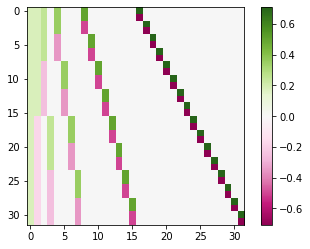

In [5]:
K=32 #size of the dictionary, must be a power of 2
U = np.transpose(haarMatrix(K)/np.sqrt(K))
#we must always have a normalization factor of sqrt(K) 
#in front, to obtain an orthonormal basis

plt.imshow(U, cmap='PiYG', interpolation='nearest')
plt.colorbar()
plt.show()

#Note that each column represents a different wavelet

In [6]:
print(U)
print(U.shape)

[[ 0.1767767   0.1767767   0.25       ...  0.          0.
   0.        ]
 [ 0.1767767   0.1767767   0.25       ... -0.         -0.
  -0.        ]
 [ 0.1767767   0.1767767   0.25       ...  0.          0.
   0.        ]
 ...
 [ 0.1767767  -0.1767767  -0.         ... -0.         -0.70710678
  -0.        ]
 [ 0.1767767  -0.1767767  -0.         ...  0.          0.
   0.70710678]
 [ 0.1767767  -0.1767767  -0.         ... -0.         -0.
  -0.70710678]]
(32, 32)


IndexError: index 4 is out of bounds for axis 0 with size 4

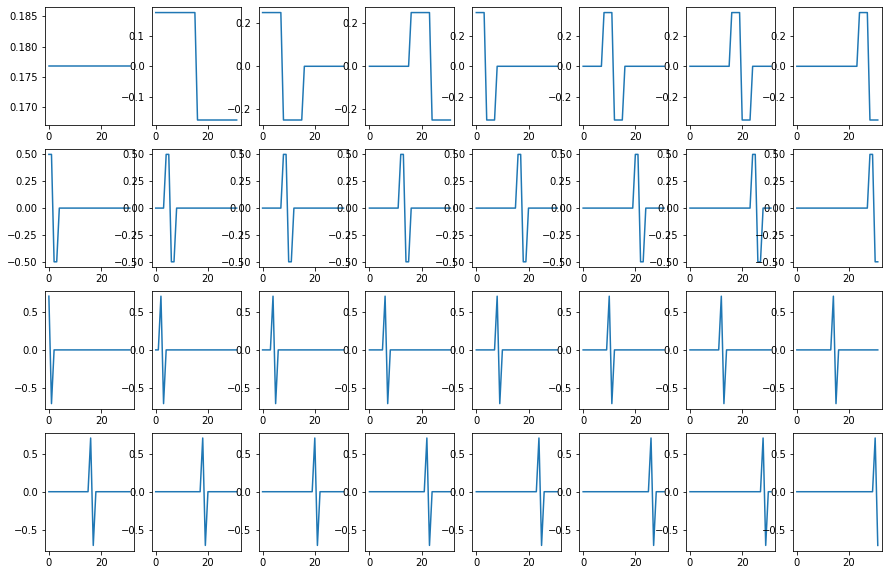

In [7]:
#note that the columns of the above matrix correspond to the
#wavelets plotted below
#note that j here corresponds to the shifting factor (b)
#and i corresponds to the scaling factor(a)


fig, axs = plt.subplots(4, 8, figsize=(15, 10))
for i in range(8):
    for j in range(8):
        axs[i,j].plot(U[:,i*8+j])

for ax in fig.get_axes():
    ax.label_outer()



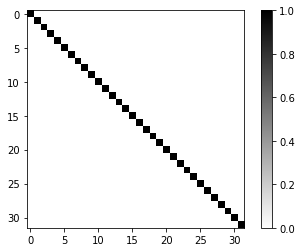

In [10]:
plt.imshow(np.dot(np.transpose(U),U),cmap='binary', interpolation='nearest')
plt.colorbar()
plt.show()

#indeed U^TU gives us identity

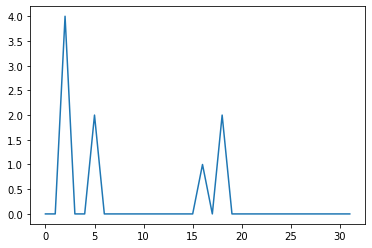

In [11]:
#First we will construct some arbitrary signal
#some arbitrary signal
signal = np.zeros((K,))
signal[2] = 4
signal[5] = 2
signal[int(K/2)] =1
signal[int(K/2)+2]=2

plt.plot(range(K),signal)

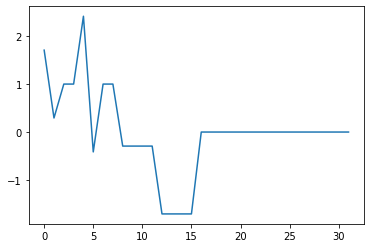

In [12]:
#now we will represent the signal in the Haar basis
signal_haar = np.dot(U, signal)
plt.plot(range(K),signal_haar)

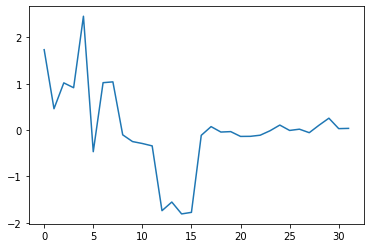

In [13]:
#now we will corrupt the signal by small Gaussian noise

noise = 0.1*np.random.normal(0,1,K)
signal_gauss_noise = signal_haar + noise
plt.plot(range(K),signal_gauss_noise)


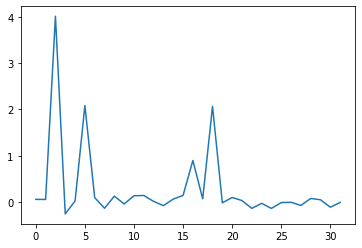

In [14]:
#now we transform the gaussian corrupted signal back in the original
#basis. For this we use U^-1 = U^T

reconstructed_signal = np.dot(np.transpose(U), signal_gauss_noise)
plt.plot(range(K), reconstructed_signal)

We note that this still spikes at the same location as the original created signal

In [15]:
#Now we will apply different thresholdings on signal in the Haar basis
#that is corrupted by gaussian noise

reconstructed_signal[reconstructed_signal<0.2]=0


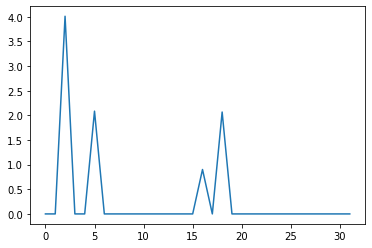

In [16]:
plt.plot(range(K), reconstructed_signal)

We note that for tresholding at 0.2, we almost get back the original signal

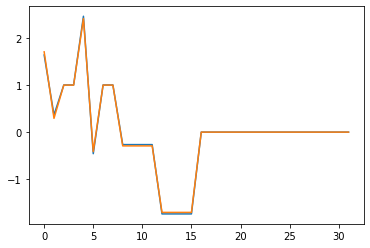

In [17]:
#note that this is still in the Haar basis
#therefore we will plot it together with the original 
#signal represented in the Haar basis
RS = np.dot(U, reconstructed_signal)
plt.plot(range(K), RS, range(K), signal_haar)

Indeed the wave is almost reconstructed entirely correctly

# Fast Fourier Transform

In [19]:
from skimage import io 


Task A: Fourier Transform of Images: we compare the Fourier transform of two different images. The following functions can be used to compute a Fourier transform of a given image. Note that low frequencies are 
        shifted to the center of the transformed image.

In [20]:
def fourier_transform(img):
    f = np.fft.fft2(img)
    # shift the zero-frequency component to the center of the spectrum
    fshift = np.fft.fftshift(f)
    return fshift

def inverse_fourier_transform(f):
    # shift the zero-frequency component back to the original place
    f = np.fft.fftshift(f)
    img = abs(np.fft.ifft2(f))
    return img

def get_fourier_magnitude_spectrum(img):
    f = fourier_transform(img)
    magnitude_spectrum = 20*np.log(np.abs(f))
    return magnitude_spectrum

def plot_img(img):
    plt.imshow(img, cmap='gray')
    
def plot_img_with_fourier_spectrum(img, fourier_magnitude_spectrum):
    plt.subplot(121)
    plot_img(img)
    plt.subplot(122)
    plot_img(fourier_magnitude_spectrum)

Here we plot the magnitude spectrum of two different images. Answer the following questions:
What is the difference between these two spectrums?
What is the source of this difference in spectrums?

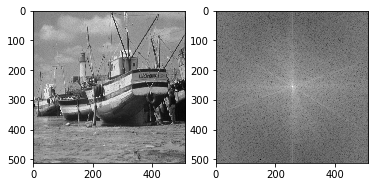

In [22]:
img_boat = io.imread("boat.png")
f_boat = get_fourier_magnitude_spectrum(img_boat)
plot_img_with_fourier_spectrum(img_boat, f_boat)

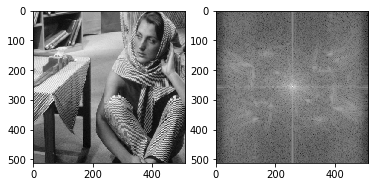

In [23]:
img_barbara = io.imread("barbara.png")
f_barbara = get_fourier_magnitude_spectrum(img_barbara)
plot_img_with_fourier_spectrum(img_barbara, f_barbara)


The following function constructs a mask that you'll need for the next exercises.

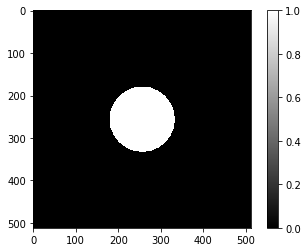

In [24]:
def get_mask(nrows, ncols, keep_frac=0.1):
    row, col = np.ogrid[:nrows, :ncols]
    cnt_row, cnt_col = nrows / 2, ncols / 2
    radius = np.sqrt(keep_frac*nrows*ncols/np.pi)
    outer_disk_mask = ((row - cnt_row)**2 + (col - cnt_col)**2 < radius ** 2)
    return outer_disk_mask.astype(float)

mask = get_mask(*img_boat.shape, keep_frac=0.07)
plot_img(mask)
plt.colorbar()

Task B: Use the shifted fourier spectrum together with the above mask to implement a lowpass filtering. The steps to accomplish this task are as follows. First, apply the filter (=mask) to the spectrum. Then, use the inverse fourier transform to reconstruc the image.
Compare both images to their reconstructed version.
For which is the reconstruction closer to the original version? Why?

# Compressed Sensing 

In [1]:
import sklearn.linear_model as linear_model

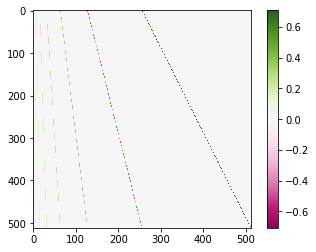

In [18]:
D = 512 #size of the dictionary. MUST be a power of 2.
U = np.transpose(haarMatrix(D)/np.sqrt(D)) #computing dictionary matrix. 
plt.imshow(U, cmap='PiYG', interpolation='nearest')
plt.colorbar()
plt.show()

TASK A : generate a random signal $x = Uz$ for some $z$ s.t. $\|z\|_0\ll D$ and project it to $M\ll D$ random directions, which you encode in a matrix $W$. Call the resulting vector $Wx =: y\in\mathbb{R}^M$ as in the lecture. Plot $x,z,y$.


In [ ]:
#generating the sparse signal